# Week 5 - Build your own sentiment analysis model

In [1]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import string 
import warnings
warnings.filterwarnings('ignore')
import re

#### 1. Get the stemmed data using the same process you did in Week 3.

In [2]:
labeled_train_data_df = pd.read_csv('labeledTrainData.tsv', sep='\t') 

print(labeled_train_data_df.shape)
labeled_train_data_df.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
labeled_train_data_df = pd.DataFrame(labeled_train_data_df[['sentiment','review']])
labeled_train_data_df.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [4]:
# Function to remove special characters and spaces
def clean_data(text): 
    text=text.lower() #makes text lowercase
    text=re.sub('\\d|\\W+|_',' ',text) #removes extra white space
    text=re.sub('[^a-zA-Z0-9]'," ", text) #removes any non-alphanumeric characters
    
    return text

In [5]:
# Function to remove stop words (and tokenize)
def Tokenize_and_RemoveStopWords(txt): 
    from nltk import word_tokenize
    from nltk.corpus import stopwords 
       
    txt_token = word_tokenize(txt)
    stop_words = stopwords.words('english') 
    txt_no_stopwords = [word for word in txt_token if word not in stop_words]
    
    return txt_no_stopwords

In [6]:
# Apply NLTK's PorterStemmer 
def stem_text(word_list):
    from nltk.stem.porter import PorterStemmer
    
    porter = PorterStemmer()
    return [porter.stem(word) for word in word_list]

In [7]:
#creating new columns in the data frame for each preprocessing step
labeled_train_data_df['review_clean'] = labeled_train_data_df.review.apply(clean_data)
print(labeled_train_data_df.shape)

#applying tokenizing and remove stop words 
labeled_train_data_df['review_tokenized'] = labeled_train_data_df.review_clean.apply(Tokenize_and_RemoveStopWords)
print(labeled_train_data_df.shape)

#applying PorterStemmer 
labeled_train_data_df['review_stemmed'] = labeled_train_data_df.review_tokenized.apply(stem_text)
print(labeled_train_data_df.shape)

#putting the text back together  
labeled_train_data_df['review_final'] = labeled_train_data_df.review_stemmed.apply(lambda text: ' '.join(text))

print(labeled_train_data_df.shape)
labeled_train_data_df.head()

(25000, 3)
(25000, 4)
(25000, 5)
(25000, 6)


,sentiment,review,review_clean,review_tokenized,review_stemmed,review_final
0,1,With all this stuff going down at the moment w...,with all this stuff going down at the moment w...,"[stuff, going, moment, mj, started, listening,...","[stuff, go, moment, mj, start, listen, music, ...",stuff go moment mj start listen music watch od...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",the classic war of the worlds by timothy hine...,"[classic, war, worlds, timothy, hines, enterta...","[classic, war, world, timothi, hine, entertain...",classic war world timothi hine entertain film ...
2,0,The film starts with a manager (Nicholas Bell)...,the film starts with a manager nicholas bell g...,"[film, starts, manager, nicholas, bell, giving...","[film, start, manag, nichola, bell, give, welc...",film start manag nichola bell give welcom inve...
3,0,It must be assumed that those who praised this...,it must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme...","[must, assum, prais, film, greatest, film, ope...",must assum prais film greatest film opera ever...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy and wondrously unpretentious ...,"[superbly, trashy, wondrously, unpretentious, ...","[superbl, trashi, wondrous, unpretenti, exploi...",superbl trashi wondrous unpretenti exploit hoo...


In [8]:
# column types of each column
labeled_train_data_df.dtypes

sentiment            int64
review              object
review_clean        object
review_tokenized    object
review_stemmed      object
review_final        object
dtype: object

#### 2. Split this into a training and test set.

In [9]:
from sklearn.model_selection import train_test_split

x = labeled_train_data_df['review_final'] 
#x = labeled_train_data_df.drop('review_final',axis=1) 
y = labeled_train_data_df['sentiment']
 
#80% for Training and 20% for Test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [10]:
print('x train : ',x_train.shape)
print('x test : ',x_test.shape)
print('y train : ',y_train.shape)
print('y test : ',y_test.shape)

## Display number of sentiments in training and test sets 
print(y_train.value_counts())
print(y_test.value_counts())

x train :  (20000,)
x test :  (5000,)
y train :  (20000,)
y test :  (5000,)
0    10010
1     9990
Name: sentiment, dtype: int64
1    2510
0    2490
Name: sentiment, dtype: int64


In [11]:
# Frequency of the word in a document using term frequency-inverse document frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_matrix_train = tfidf.fit_transform(x_train)

# Check the shape to validate tf-idf vectorization
tfidf_matrix_train.shape

(20000, 45326)

In [12]:
tfidf_matrix_test = tfidf.transform(x_test)

# Check the shape to validate
tfidf_matrix_test.shape

(5000, 45326)

#### 3. Fit and apply the tf-idf vectorization to the training set.

In [13]:
# Create the tf-idf feature matrix for training data
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfs = TfidfVectorizer()
x_train_tdif = tfidfs.fit_transform(x_train)

x_train_tdif.shape 

(20000, 45326)

#### 4. Apply but DO NOT FIT the tf-idf vectorization to the test set (Why?).

In [14]:
# Create the tf-idf feature matrix for test data
x_test_tdif = tfidf.transform(x_test)

# Check the shape to validate
x_test_tdif.shape

(5000, 45326)

We expect maximum accuracy from the training set. We do not fit the tf-idf to test set because doing so would cause test data to leak into the training set. Surprisingly high accuracy score could indicate that test data leaked into the training set.

#### 5. Train a logistic regression using the training data.

In [15]:
from sklearn.linear_model import LogisticRegression
    
logistic_model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
pred = logistic_model.fit(x_train_tdif, y_train).predict(x_test_tdif) 
pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

#### 6. Find the model accuracy on test set.

In [16]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, pred)
print('Logistic Regression Accuracy score:',score)
#The model has a 88.3% accuracy score

Logistic Regression Accuracy score: 0.893


#### 7. Create a confusion matrix for the test set predictions.

[[2190  300]
 [ 235 2275]]


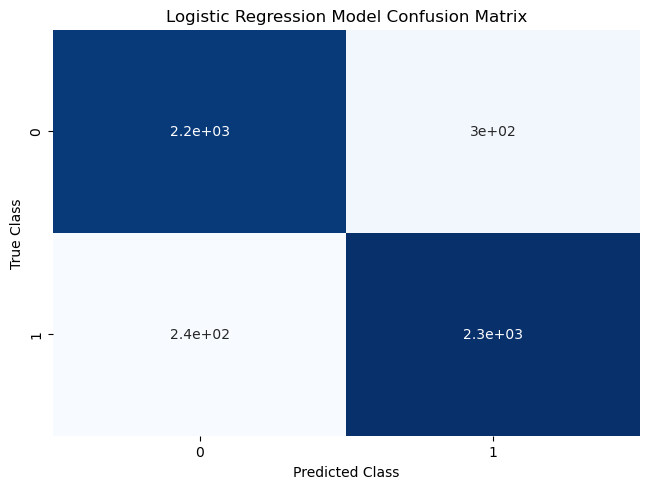

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, pred, labels=[1,0])

matrix = confusion_matrix(y_test, pred)
print(matrix)

# Create pandas dataframe
df = pd.DataFrame(matrix)

# Create a heatmap
sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Logistic Regression Model Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

#### 8. Get the precision, recall, and F1-score for the test set predictions.

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision
p = "{:.0%}".format(precision_score(y_test, pred))

# Calculate Recall
r = "{:.0%}".format(recall_score(y_test, pred))

# Calculate F1-score
f1 = "{:.0%}".format(f1_score(y_test, pred))

# Print results
print("Precision:",p)
print("Recall:",r)
print("F1-score:",f1)

Precision: 88%
Recall: 91%
F1-score: 89%


#### 9. Create a ROC curve for the test set.

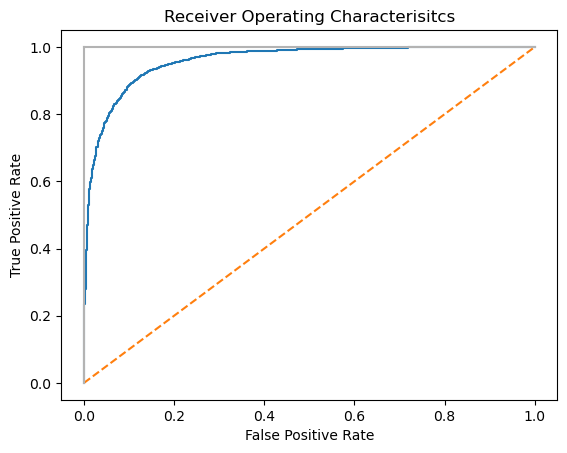

In [19]:
# Load libraries
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
target_probabilities = logistic_model.predict_proba(x_test_tdif)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characterisitcs")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()


#### 10. Pick another classification model you learned about this week and repeat steps (5) – (9).

###### 10.5.Train a logistic regression using the training data.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
 
# Train a KNN classifier with 5 neighbors
knnmodel = KNeighborsClassifier()
prediction = knnmodel.fit(x_train_tdif, y_train).predict(x_test_tdif) 
prediction

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

###### 10.6. Find the model accuracy on test set.

In [21]:
score = accuracy_score(y_test, prediction)
print('Knn Model Accuracy score:',score) 

Knn Model Accuracy score: 0.7854


###### 10.7. Create a confusion matrix for the test set predictions.

[[1812  678]
 [ 395 2115]]


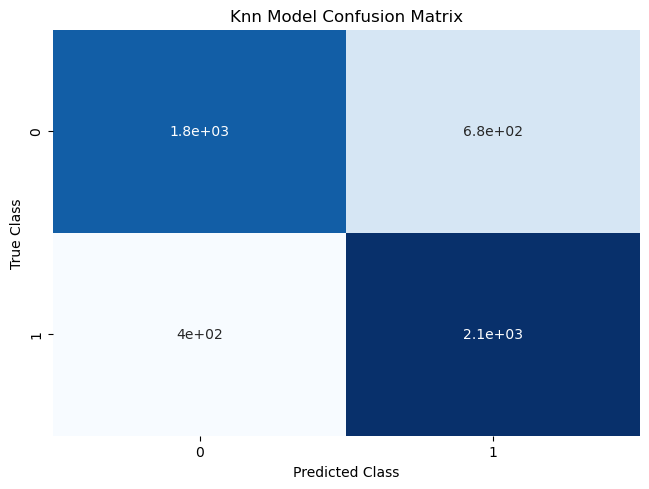

In [22]:
matrix = confusion_matrix(y_test, prediction, labels=[1,0])

matrix = confusion_matrix(y_test, prediction)
print(matrix)
# Create pandas dataframe
df = pd.DataFrame(matrix)

# Create a heatmap
sns.heatmap(df, annot=True, cbar=None, cmap="Blues")
plt.title("Knn Model Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

###### 10.8 Get the precision, recall, and F1-score for the test set predictions.

In [23]:
# Calculate Precision
p = "{:.0%}".format(precision_score(y_test, prediction))

# Calculate Recall
r = "{:.0%}".format(recall_score(y_test, prediction))

# Calculate F1-score
f1 = "{:.0%}".format(f1_score(y_test, prediction))

# Print results
print("Precision:",p)
print("Recall:",r)
print("F1-score:",f1)

Precision: 76%
Recall: 84%
F1-score: 80%


###### 10.9 Create a ROC curve for the test set.

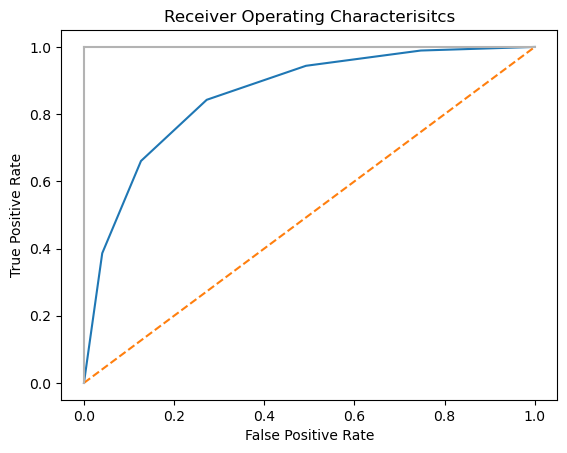

In [24]:
target_probabilities = knnmodel.predict_proba(x_test_tdif)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characterisitcs")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()